In [3]:
import torch
import torch.distributions as dist

In [4]:
class GR4J(object):

    _params = {
        'x1': dist.uniform.Uniform(100, 1200).sample(),
        'x2': dist.uniform.Uniform(-3, 5).sample(),
        'x3': dist.uniform.Uniform(20, 300).sample(),
        'x4': dist.uniform.Uniform(1, 3).sample()
    }

    def __init__(self, s_init=0, r_init=0):
        self.s_init = s_init
        self.r_init = r_init

    def update_params(self, x1, x2, x3, x4):
        self._params = {
            'x1': x1,
            'x2': x2,
            'x3': x3,
            'x4': x4
        }

    def _s_curve1(self, t, x4):
        """Calculate the s-curve of the unit-hydrograph 1.
        
        Args:
            t: timestep
            x4: model parameter x4 of the gr4j model.
            
        """
        if t <= 0:
            return 0.
        elif t < x4:
            return (t / x4)**2.5
        else:
            return 1.


    def _s_curve2(self, t, x4): 
        """Calculate the s-curve of the unit-hydrograph 2.
        
        Args:
            t: timestep
            x4: model parameter x4 of the gr4j model.
            
        """
        if t <= 0:
            return 0.
        elif t <= x4:
            return 0.5 * ((t / x4) ** 2.5)
        elif t < 2*x4:
            return 1 - 0.5 * ((2 - t / x4) ** 2.5)
        else:
            return 1.
    
    def run(self, prec, etp):
        
        # Number of simulation timesteps
        num_timesteps = len(prec)
        
        # Unpack the model parameters
        x1 = self._params['x1']
        x2 = self._params['x2']
        x3 = self._params['x3']
        x4 = self._params['x4']
        
        # initialize empty arrays for discharge and all storages
        s_store = torch.zeros(num_timesteps+1)
        r_store = torch.zeros(num_timesteps+1)
        qsim = torch.zeros(num_timesteps+1)
        
        # for clean array indexing, add 0 element at the 0th index of prec and 
        # etp so we start simulating at the index 1
        prec = torch.concat((torch.zeros(1), prec))
        etp = torch.concat((torch.zeros(1), etp))
        
        # set initial values
        s_store[0] = self.s_init * x1
        r_store[0] = self.r_init * x3
        
        # calculate number of unit hydrograph ordinates
        num_uh1 = int(torch.ceil(x4))
        num_uh2 = int(torch.ceil(2*x4 + 1))
        
        # calculate the ordinates of both unit-hydrographs (eq. 16 & 17)
        uh1_ordinates = torch.zeros(num_uh1)
        uh2_ordinates = torch.zeros(num_uh2)
        
        for j in range(1, num_uh1 + 1):
            uh1_ordinates[j - 1] = self._s_curve1(j, x4) - self._s_curve1(j - 1, x4)
            
        for j in range(1, num_uh2 + 1):
            uh2_ordinates[j - 1] = self._s_curve2(j, x4) - self._s_curve2(j - 1, x4)
        
        # arrys to store the rain distributed through the unit hydrographs
        uh1 = torch.zeros(num_uh1)
        uh2 = torch.zeros(num_uh2)
        
        # Start the model simulation loop
        for t in range(1, num_timesteps+1):
            
            # Calculate netto precipitation and evaporation
            if prec[t] >= etp[t]:
                p_n = prec[t] - etp[t]
                pe_n = 0
            
                # calculate fraction of netto precipitation that fills
                #  production store (eq. 3)
                p_s = ((x1 * (1 - (s_store[t-1] / x1)**2) * torch.tanh(p_n/x1)) /
                    (1 + s_store[t-1] / x1 * torch.tanh(p_n / x1)))
                
                # no evaporation from production store
                e_s = 0   
            
            else:
                p_n = 0
                pe_n = etp[t] - prec[t]
                
                # calculate the fraction of the evaporation that will evaporate 
                # from the production store (eq. 4)
                e_s = ((s_store[t-1] * (2 - s_store[t-1]/x1) * torch.tanh(pe_n/x1)) 
                    / (1 + (1 - s_store[t-1] / x1) * torch.tanh(pe_n / x1)))
                
                # no rain that is allocation to the production store
                p_s = 0
                
            # Calculate the new storage content
            s_store[t] = s_store[t-1] - e_s + p_s
            
            # calculate percolation from actual storage level
            perc = s_store[t] * (1 - (1 + (4/9 * s_store[t] / x1)**4)**(-0.25))
            
            # final update of the production store for this timestep
            s_store[t] = s_store[t] - perc
            
            # total quantity of water that reaches the routing
            p_r = perc + (p_n - p_s)
            
            # split this water quantity by .9/.1 for diff. routing (UH1 & UH2)
            p_r_uh1 = 0.9 * p_r 
            p_r_uh2 = 0.1 * p_r
            
            # update state of rain, distributed through the unit hydrographs
            for j in range(0, num_uh1 - 1):
                uh1[j] = uh1[j + 1] + uh1_ordinates[j] * p_r_uh1
            uh1[-1] = uh1_ordinates[-1] * p_r_uh1
            
            for j in range(0, num_uh2 - 1):
                uh2[j] = uh2[j + 1] + uh2_ordinates[j] * p_r_uh2
            uh2[-1] = uh2_ordinates[-1] * p_r_uh2
            
            # calculate the groundwater exchange F (eq. 18)
            gw_exchange = x2 * (r_store[t - 1] / x3) ** 3.5
            
            # update routing store
            r_store[t] = max(0, r_store[t - 1] + uh1[0] + gw_exchange)
            
            # outflow of routing store
            q_r = r_store[t] * (1 - (1 + (r_store[t] / x3)**4)**(-0.25))
            
            # subtract outflow from routing store level
            r_store[t] = r_store[t] - q_r
            
            # calculate flow component of unit hydrograph 2
            q_d = max(0, uh2[0] + gw_exchange)
            
            # total discharge of this timestep
            qsim[t] = q_r + q_d
            
        # return all but the artificial 0's step
        return qsim[1:], s_store[1:], r_store[1:]

In [5]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
data_location = os.path.join('/data')

In [7]:
# Calibration period
calib_start_year = 1990
calib_end_year = 2000

# Holdout period
holdout_start_year = 2000
holdout_end_year = 2005

In [8]:
# Load the data
maulescreek_rain_et = pd.read_csv(
    os.path.join(
        data_location,
        'SILO(-30.5,150.1)',
        'FAO56_Penman_Monteith_1989.csv'
    )
)
maulescreek_streamflow = pd.read_csv(
    os.path.join(
        data_location,
        'water_level',
        'bom_gauge_daily_mean_419051.csv'
    )
)

# fix dates 
maulescreek_rain_et['Date'] = pd.to_datetime(maulescreek_rain_et['Date2'],format="%d-%m-%Y")
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Timestamp'],utc=True, format='%Y-%m-%d')
maulescreek_streamflow['Date'] = maulescreek_streamflow['Date'].dt.date
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Date'])

In [9]:
# 
merged_data = pd.merge(
    maulescreek_rain_et,
    maulescreek_streamflow,
    left_on='Date',
    right_on='Date'
)

# Slicing the data into calibration and holdout
calibration_data = merged_data.loc[((merged_data['Date']).dt.year >= calib_start_year) & ((merged_data['Date']).dt.year < calib_end_year)].reset_index(drop=True)

holdout_data = merged_data.loc[((merged_data['Date']).dt.year >= holdout_start_year) & ((merged_data['Date']).dt.year < holdout_end_year)].reset_index(drop=True)

In [10]:
# Tune GR4J parameters
prcp_calib = torch.from_numpy(calibration_data.loc[:, 'Rain'].values)
et_calib = torch.from_numpy(calibration_data.loc[:, 'FAO56'].values)
flow_calib = torch.from_numpy(calibration_data.loc[:, 'Value'].values)
date_calib = calibration_data.loc[:, 'Date'].values


In [11]:
model = GR4J()

model.update_params(
    torch.tensor(109.37697209637108),
    torch.tensor(2.1414661782132125), 
    torch.tensor(20.0),
    torch.tensor(1.1)
)

result = model.run(prec=prcp_calib, etp=et_calib)

In [12]:
result[0]

tensor([0.0000, 0.0000, 0.0000,  ..., 0.6106, 0.6066, 0.6026])

In [13]:
def nse(targets, predictions):
    return 1-(torch.sum((targets-predictions)**2)/torch.sum((targets-torch.mean(targets))**2))

def normalize(x):
    return 1/(2 - x)

def evaluate(model, dates, et, prcp, flow):
    
    flow_pred = model.run(prcp, et)[0]

    nse_score = nse(flow, flow_pred)
    nnse_score = normalize(nse_score)

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(dates, flow, label='obs')
    ax.plot(dates, flow_pred, label='pred')

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

NSE: 0.127
Normalized NSE: 0.534


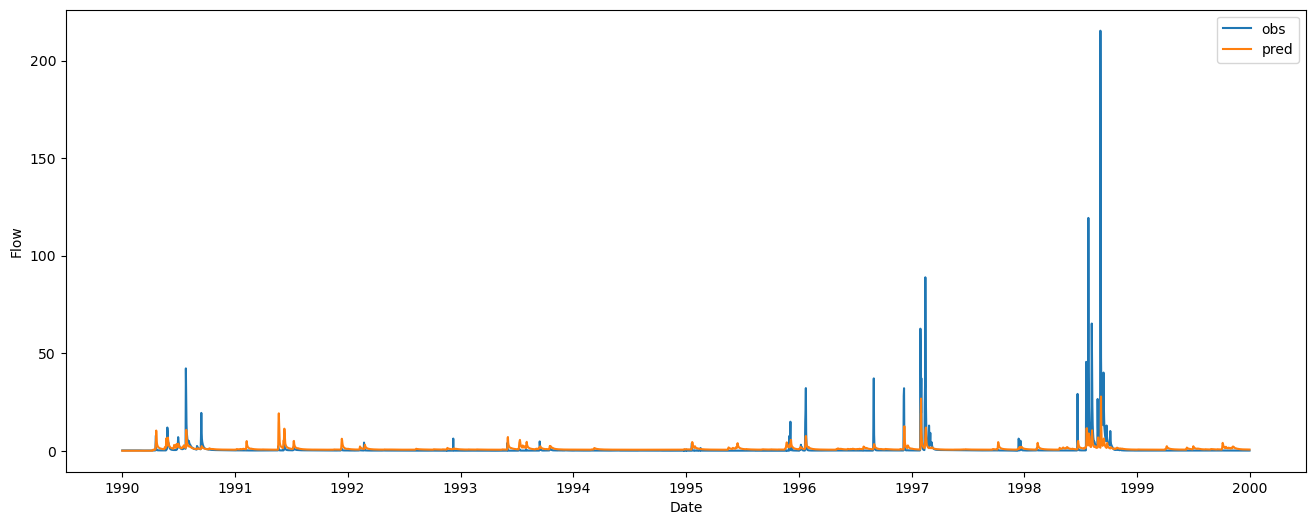

In [14]:
evaluate(model, date_calib,  et_calib, prcp_calib, flow_calib)

NSE: 0.009
Normalized NSE: 0.502


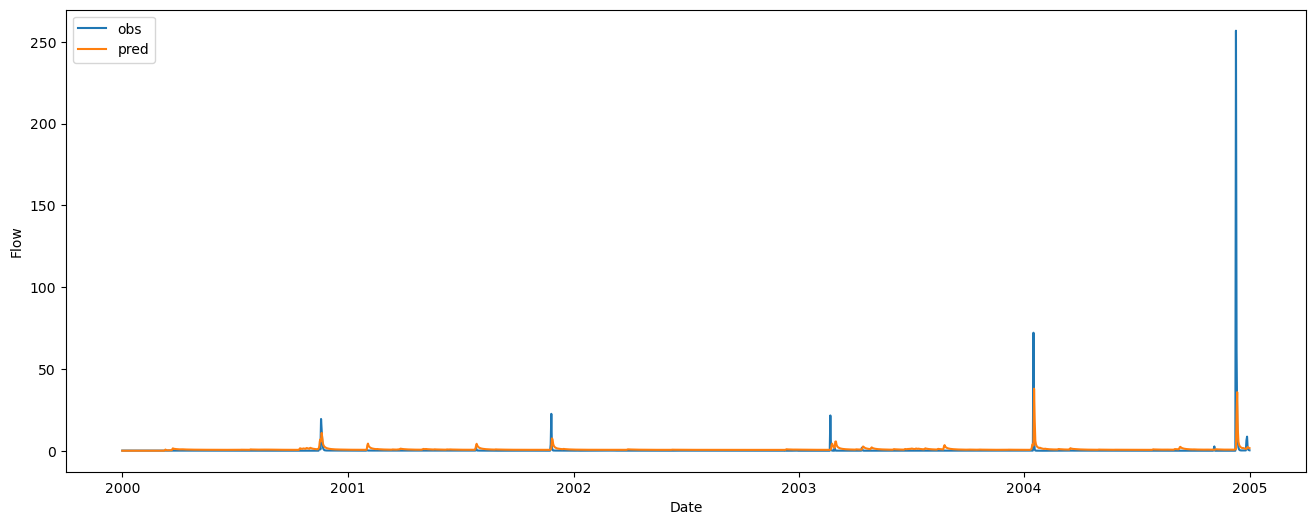

In [16]:
# Evaluate on unseen data
prcp_holdout = torch.from_numpy(holdout_data.loc[:, 'Rain'].values)
et_holdout= torch.from_numpy(holdout_data.loc[:, 'FAO56'].values)
flow_holdout = torch.from_numpy(holdout_data.loc[:, 'Value'].values)
date_holdout = holdout_data.loc[:, 'Date'].values

evaluate(model, date_holdout,  et_holdout, prcp_holdout, flow_holdout)
